<a href="https://colab.research.google.com/github/robonesky/oreilly/blob/main/RM%20Lab%20Notes%209%20202301%20cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# In previous cohorts, this lab has focused on using the Boston housing dataset.
# Kannan has now moved it to use the Nifty 50

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:,.2f}'.format

%pip install watermark

from watermark import watermark
%load_ext watermark
%watermark -a "Rob Onesky" -u -d -v -m -iv

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Rob Onesky

Last updated: 2023-06-15

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.107+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.5.3
matplotlib: 3.7.1
numpy     : 1.22.4
seaborn   : 0.12.2



In [5]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
    index_col = 0#,
    #dayFirst = True
)

df

,Open,High,Low,Close,Volume
02/01/2012,"4,640.20","4,645.95","4,588.05","4,636.75",108461000
03/01/2012,"4,675.80","4,773.10","4,675.80","4,765.30",146621008
04/01/2012,"4,774.95","4,782.85","4,728.85","4,749.65",165939008
05/01/2012,"4,749.00","4,779.80","4,730.15","4,749.95",177863008
06/01/2012,"4,724.15","4,794.90","4,686.85","4,754.10",176057008
...,...,...,...,...,...
26/12/2022,"17,830.40","18,084.10","17,774.25","18,014.60",176652336
27/12/2022,"18,089.80","18,149.25","17,967.45","18,132.30",214257088
28/12/2022,"18,084.75","18,173.10","18,068.35","18,122.50",193873168
29/12/2022,"18,045.70","18,229.70","17,992.80","18,191.00",281052832


In [6]:
df.describe()

,Open,High,Low,Close,Volume
count,"2,719.00","2,719.00","2,719.00","2,719.00","2,719.00"
mean,"10,124.90","10,175.29","10,057.47","10,117.57","289,222,065.64"
std,"3,709.61","3,725.53","3,685.31","3,706.95","195,276,778.85"
min,"4,640.20","4,645.95","4,588.05","4,636.75","2,826,000.00"
25%,"7,637.00","7,681.00","7,581.65","7,623.80","159,178,008.00"
50%,"9,376.95","9,431.90","9,301.35","9,351.85","219,496,064.00"
75%,"11,700.85","11,755.12","11,631.33","11,684.00","340,908,832.00"
max,"18,871.95","18,887.60","18,778.20","18,812.50","1,810,971,008.00"


In [7]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:


# create features
def create_features(frame):
    df = frame.copy()
    multiplier = 2

    # spy features
    df['OC'] = df['Close'] / df['Open'] - 1
    df['HC'] = df['High'] / df['Low'] - 1
    df['GAP'] = df['Open'] / df['Close'].shift(1) - 1
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))

    for i in [3]:
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['OC'+ str(i)] = df['OC'].rolling(i).mean()
        df['HC'+ str(i)] = df['HC'].rolling(i).mean()
        df['GAP'+ str(i)] = df['GAP'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()
        df['UB'+str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        df['LB'+str(i)] = df['Close'].rolling(i).mean() - df['Close'].rolling(i).std() * multiplier

    df['Label'] = df['Close'].shift(-1)

    # drop NaN values
    df.dropna(inplace=True)
    return df





In [9]:
df = create_features(df)
display(df.shape)

(2715, 18)

In [10]:
X = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Label'], axis=1)
X

,OC,HC,GAP,RET,RET3,MA3,OC3,HC3,GAP3,STD3,UB3,LB3
05/01/2012,0.00,0.01,-0.00,0.00,0.02,1.00,0.00,0.01,0.00,0.02,"4,772.87","4,737.07"
06/01/2012,0.01,0.02,-0.01,0.00,-0.00,1.00,0.00,0.01,-0.00,0.00,"4,756.21","4,746.26"
09/01/2012,-0.00,0.01,-0.00,-0.00,-0.00,1.00,0.00,0.02,-0.00,0.00,"4,760.38","4,737.52"
10/01/2012,0.02,0.02,0.01,0.02,0.02,1.01,0.01,0.02,-0.00,0.01,"4,899.44","4,664.86"
11/01/2012,-0.00,0.01,0.00,0.00,0.02,1.01,0.00,0.01,0.00,0.01,"4,948.11","4,687.42"
...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.01,0.02,-0.01,-0.02,-0.03,0.99,-0.01,0.02,-0.00,0.01,"18,462.19","17,626.65"
26/12/2022,0.01,0.02,0.00,0.01,-0.01,1.00,-0.00,0.02,-0.00,0.01,"18,308.13","17,657.70"
27/12/2022,0.00,0.01,0.00,0.01,0.00,1.01,0.00,0.01,-0.00,0.02,"18,314.20","17,654.94"
28/12/2022,0.00,0.01,-0.00,-0.00,0.02,1.00,0.00,0.01,0.00,0.01,"18,220.42","17,959.18"


In [11]:
y = np.array(df['Label'])
y

array([ 4754.1 ,  4742.8 ,  4849.55, ..., 18122.5 , 18191.  , 18105.3 ])

Text(0.5, 1.0, 'Feature set correlations')

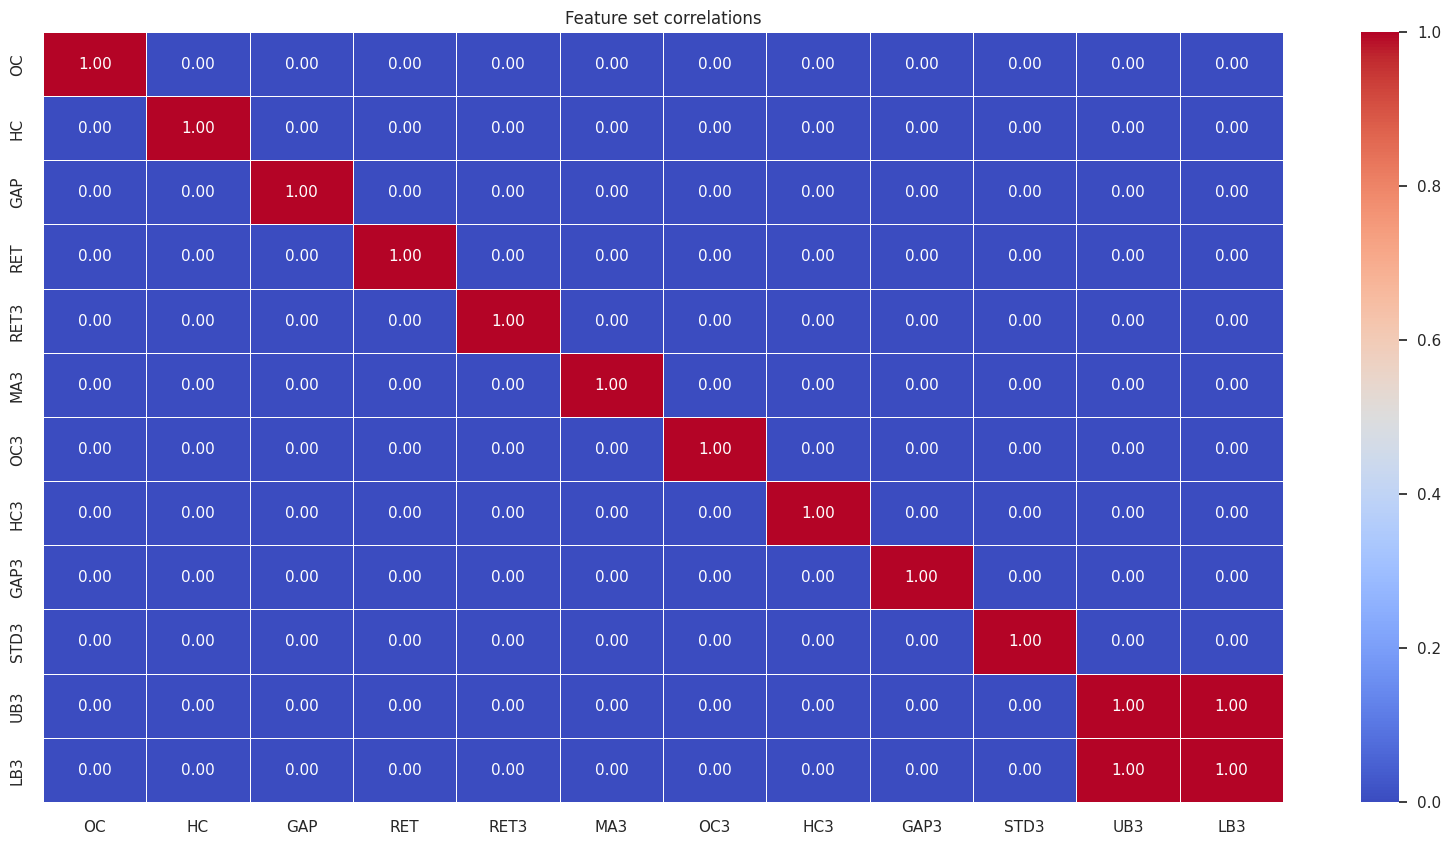

In [15]:

sns.set(rc =  {'figure.figsize': (20, 10)})
sns.heatmap(
    X.corr() > 0.9,
    annot = True,
    annot_kws = {'size': 11},
    fmt = '.2f',
    linewidth = 0.5,
    cmap = 'coolwarm',
    cbar = True
)

plt.title('Feature set correlations')

In [16]:
# LB3 and UB3 are perfectly correlated with each other.  Drop one of them
to_drop = ['LB3']
X.drop(to_drop, axis=1, inplace=True)

#record feature names
feature_names = X.columns

# Now let's see what X looks like now
X

,OC,HC,GAP,RET,RET3,MA3,OC3,HC3,GAP3,STD3,UB3
05/01/2012,0.00,0.01,-0.00,0.00,0.02,1.00,0.00,0.01,0.00,0.02,"4,772.87"
06/01/2012,0.01,0.02,-0.01,0.00,-0.00,1.00,0.00,0.01,-0.00,0.00,"4,756.21"
09/01/2012,-0.00,0.01,-0.00,-0.00,-0.00,1.00,0.00,0.02,-0.00,0.00,"4,760.38"
10/01/2012,0.02,0.02,0.01,0.02,0.02,1.01,0.01,0.02,-0.00,0.01,"4,899.44"
11/01/2012,-0.00,0.01,0.00,0.00,0.02,1.01,0.00,0.01,0.00,0.01,"4,948.11"
...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.01,0.02,-0.01,-0.02,-0.03,0.99,-0.01,0.02,-0.00,0.01,"18,462.19"
26/12/2022,0.01,0.02,0.00,0.01,-0.01,1.00,-0.00,0.02,-0.00,0.01,"18,308.13"
27/12/2022,0.00,0.01,0.00,0.01,0.00,1.01,0.00,0.01,-0.00,0.02,"18,314.20"
28/12/2022,0.00,0.01,-0.00,-0.00,0.02,1.00,0.00,0.01,0.00,0.01,"18,220.42"


In [17]:
X.describe()

,OC,HC,GAP,RET,RET3,MA3,OC3,HC3,GAP3,STD3,UB3
count,"2,715.00","2,715.00","2,715.00","2,715.00","2,715.00","2,715.00","2,715.00","2,715.00","2,715.00","2,715.00","2,715.00"
mean,-0.00,0.01,0.00,0.00,0.00,1.00,-0.00,0.01,0.00,0.01,"10,252.58"
std,0.01,0.01,0.01,0.01,0.02,0.01,0.00,0.01,0.00,0.01,"3,749.88"
min,-0.07,0.00,-0.09,-0.14,-0.16,0.93,-0.05,0.00,-0.05,0.00,"4,756.21"
25%,-0.01,0.01,-0.00,-0.00,-0.01,1.00,-0.00,0.01,-0.00,0.00,"7,748.51"
50%,-0.00,0.01,0.00,0.00,0.00,1.00,-0.00,0.01,0.00,0.01,"9,496.35"
75%,0.00,0.01,0.00,0.01,0.01,1.01,0.00,0.01,0.00,0.01,"11,846.27"
max,0.09,0.19,0.04,0.08,0.13,1.05,0.03,0.10,0.02,0.11,"18,930.34"


In [19]:


class Regression:
    def __init__(self, X, y, testsize=0.20):

        self.X = X
        self.y = y
        self.testsize = testsize

        # split training and testing dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                                                                self.y,
                                                                                test_size=self.testsize,
                                                                                random_state=0,
                                                                                shuffle=False)

    # fit and predict
    def fit_predict(self, estimator, transformer, alpha=None, l1_ratio=None):

        try:
            # subsume estimators and transformer into a pipeline
            model = Pipeline([
            ('scaler', transformer),
            ('regressor', estimator)
            ])

            # fit/train model
            model.fit(self.X_train, self.y_train)

            # predict lables
            y_pred = model.predict(self.X_test)

        except Exception as e:
            print(str(e))

        return model, model['regressor'].intercept_, model['regressor'].coef_, y_pred

    # evaluate metrics
    def eval_metrics(self,model, y_pred):

        # evaluate metrics
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2train = model.score(self.X_train, self.y_train)
        r2test = model.score(self.X_test, self.y_test)

        return mse, rmse, r2train, r2test

    # plot coefficients as a function of lambda
    def plot_coeff(self, modelname):

        coef = []
        model = Regression(self.X, self.y, 0.20)
        alpha_range = np.logspace(2, -2, 200)

        if modelname == 'Lasso':
            for i in alpha_range:
                coef.append(model.fit_predict(Lasso(alpha=i, random_state=0), MinMaxScaler())[2])

        elif modelname == 'Ridge':
            alpha_range = np.logspace(6, -2, 200)
            for i in alpha_range:
                coef.append(model.fit_predict(Ridge(alpha=i, random_state=0), MinMaxScaler())[2])

        elif modelname == 'ElasticNet':
            for i in alpha_range:
                coef.append(model.fit_predict(ElasticNet(alpha=i, random_state=0), MinMaxScaler())[2])

        # Plot Coefficients
        fig = plt.figure(figsize=(20,8))
        ax = plt.axes()

        ax.plot(alpha_range, coef)
        ax.set_xscale('log')
        ax.legend(feature_names, loc=0)
        # ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
        ax.set_title(f'{modelname} coefficients as a function of the regularization')
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('$\mathbf{w}$')

        return plt.show()





In [22]:
lr = Regression(X, y)
lr_model, lr_intercept, lr_coef, lr_y_pred = lr.fit_predict(LinearRegression(), MinMaxScaler())

In [23]:
lr_model

Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

In [24]:
lr_intercept

6733.034609811917

In [25]:
lr_coef

array([-8811.45765281,  -226.80443673, -7788.61654093, 12335.03547994,
        3312.30633735,  1058.61701543, -2879.451858  ,  -481.03024078,
       -2013.17004147,  -339.5891121 ,  7604.80005647])

In [26]:
lr_y_pred

array([11834.07902708, 11796.86075804, 11881.80945993, 11694.6500994 ,
       11747.33476593, 11561.81608289, 11527.75762447, 11809.38175021,
       11966.35608659, 12216.52513596, 12410.52457194, 12606.53742737,
       12788.07550626, 12838.24424523, 12639.93958793, 12613.11245462,
       12702.64950025, 12857.36110898, 12965.51842609, 12791.69123998,
       12820.65283429, 12856.03255769, 13079.34969667, 12867.27465481,
       12972.52865026, 12904.6456969 , 13049.43680271, 13105.34830695,
       12998.47407834, 13241.67727711, 13401.15491653, 13354.59970031,
       13521.99543715, 13465.65413446, 13394.87919171, 13464.93936999,
       13473.37868938, 13642.30670983, 13745.24203708, 13694.79966071,
       13576.91153758, 13620.28846932, 13511.73887887, 13784.59521481,
       13938.74898702, 13943.51214361, 13926.51291896, 13897.84432515,
       13921.97253734, 14088.4699233 , 14189.60027229, 14017.54369161,
       14027.00776076, 14348.55154588, 14603.06640286, 14581.21448684,
      

In [27]:
# Lasso

lasso = Regression(X, y)
lasso_model, lasso_intercept, lasso_coef, lasso_y_pred = \
      lasso.fit_predict(
          Lasso(alpha=0.3, random_state=0), MinMaxScaler()
      )
lasso_model , lasso_intercept, lasso_coef, lasso_y_pred

(Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', Lasso(alpha=0.3, random_state=0))]),
 4122.748804238499,
 array([  47.6169743 , -176.00889053,    0.        ,    0.        ,
           0.        ,  873.4899316 ,   -0.        , -625.59935444,
         195.71320879, -351.94099993, 7597.62272583]),
 array([11831.18580144, 11803.74645747, 11866.08638341, 11688.37624011,
        11727.93341757, 11545.61860122, 11524.88336558, 11793.36812523,
        11949.7843791 , 12231.40069228, 12405.49080863, 12613.76757478,
        12787.47593612, 12830.57140408, 12630.12038387, 12606.72924494,
        12710.90230987, 12867.47122981, 12946.24859186, 12781.24059047,
        12819.42447283, 12849.37857519, 13071.74907318, 12882.89806793,
        12952.95166639, 12874.81209898, 13045.63444149, 13091.9377876 ,
        13003.46693038, 13228.718032  , 13387.82092758, 13357.25192126,
        13522.10210727, 13457.49855118, 13396.75464454, 13460.24945109,
        13460.7691507 , 1364

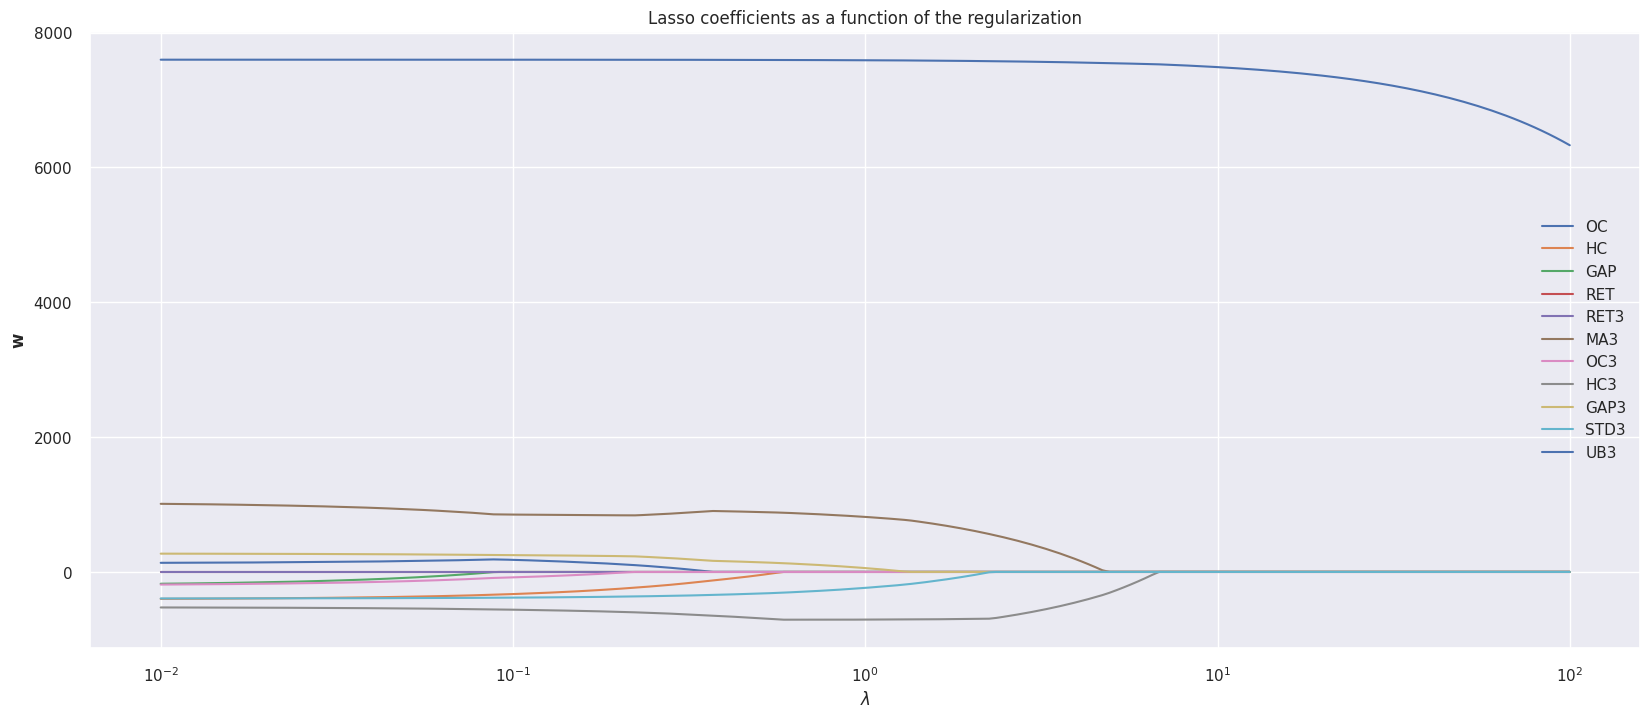

In [28]:
lasso.plot_coeff('Lasso')

In [29]:
# Ridge
ridge = Regression(X, y)

ridge_model, ridge_intercept, ridge_coef, ridge_y_pred = \
    ridge.fit_predict(
        Ridge(alpha = 1, random_state = 0),
        StandardScaler()
    )

ridge_model, ridge_intercept, ridge_coef, ridge_y_pred

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', Ridge(alpha=1, random_state=0))]),
 8577.538858195212,
 array([ -66.22807928,  -17.94110192,  -60.24200977,   88.59274746,
          67.63867793,   66.06707152,  -65.61434782,  -39.08763792,
         -24.70005904,  -25.67001916, 2116.85816033]),
 array([11836.27671528, 11788.35652903, 11874.8830068 , 11684.68813793,
        11738.76932903, 11549.10802749, 11519.77440238, 11807.20326973,
        11958.62906577, 12221.71545808, 12406.11596162, 12613.13812506,
        12786.37350995, 12832.20757631, 12632.17146457, 12605.59002887,
        12704.22136065, 12862.17333672, 12965.41252399, 12778.15180698,
        12810.34986855, 12849.21093031, 13081.01537004, 12862.61187202,
        12962.73207337, 12898.28594247, 13044.64816766, 13098.19540569,
        13000.76151452, 13239.79226227, 13398.20233674, 13350.29365908,
        13521.41070438, 13459.88297266, 13386.63385164, 13460.93742119,
        13467.82647027, 1364

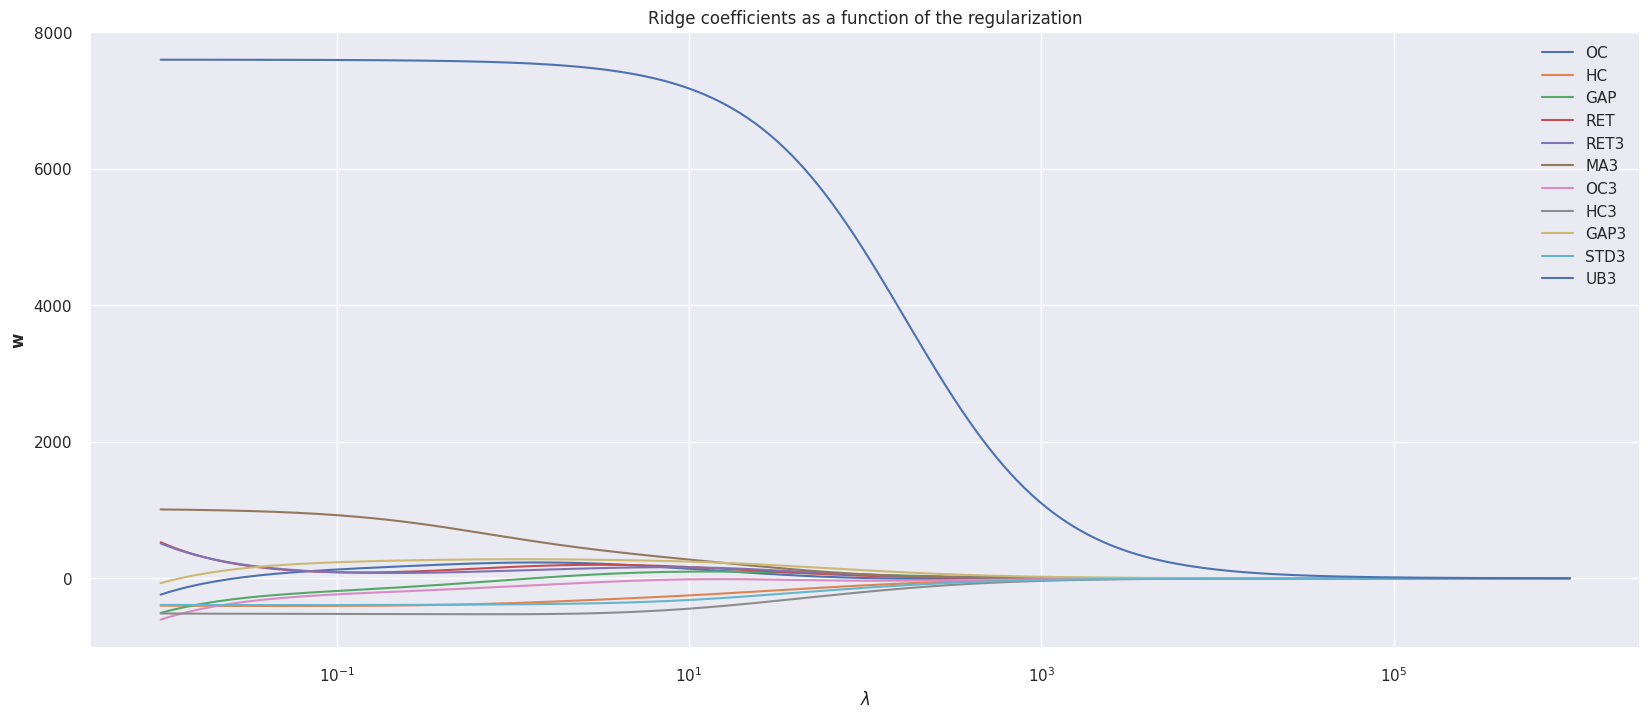

In [30]:
ridge.plot_coeff("Ridge")

In [31]:
# instantiate
elasticnet = Regression(X,y)

# fit ElasticNet
elasticnet_model , elasticnet_intercept, elasticnet_coef, elasticnet_y_pred = elasticnet.fit_predict(ElasticNet(alpha=0.1, l1_ratio=1e-10, random_state=0), StandardScaler())
elasticnet_model , elasticnet_intercept, elasticnet_coef, elasticnet_y_pred


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  ElasticNet(alpha=0.1, l1_ratio=1e-10, random_state=0))]),
 8577.538858195212,
 array([ 1.29237064e+01, -2.26506269e+01, -1.52384032e+00,  8.19537559e+00,
         1.98482983e+00,  3.48595030e+01, -1.54522883e+01, -4.82478786e+01,
         2.91346528e+01, -2.45444409e+01,  1.92284234e+03]),
 array([11550.29557484, 11495.27795904, 11585.13400457, 11389.66912086,
        11447.6675492 , 11260.06418566, 11236.12721733, 11510.24387394,
        11628.88504121, 11891.37722544, 12040.02540383, 12262.78193658,
        12401.24992712, 12444.56059818, 12255.84401854, 12228.90555492,
        12331.07757237, 12492.49115697, 12581.90871348, 12387.56253231,
        12413.74928538, 12447.08378978, 12682.98384838, 12486.32376229,
        12576.94601975, 12499.92276532, 12641.03861892, 12683.52293089,
        12620.35152344, 12823.63834576, 12958.91103554, 12912.41088026,
        13073.81926916, 13012.6892507

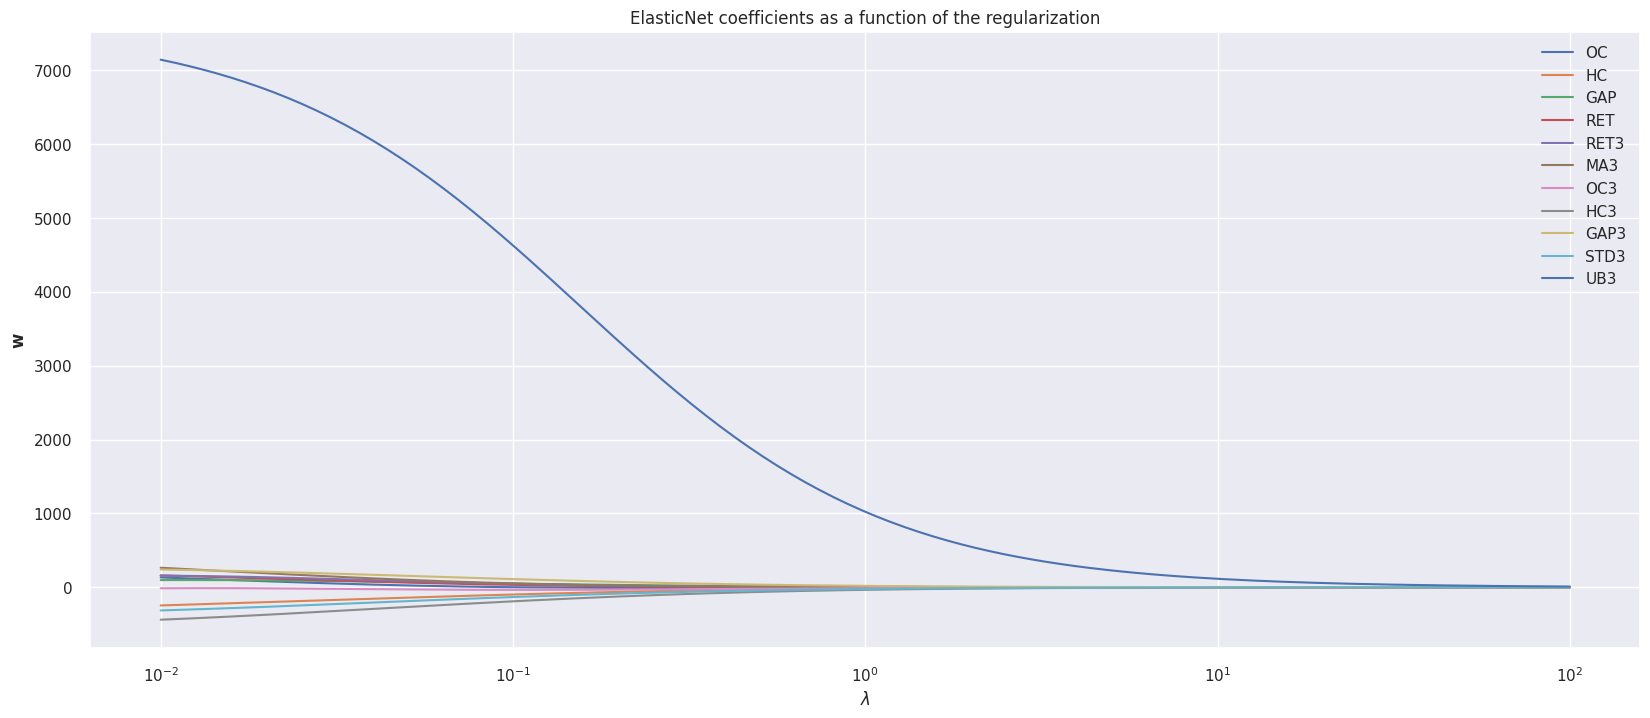

In [32]:

# plot coefficients
elasticnet.plot_coeff('ElasticNet')

In [33]:
# Model comparison
coef_df = pd.DataFrame(
    {
        'LR': lr_coef,
        'Lasso': lasso_coef,
        'Ridge': ridge_coef,
        'ElasticNet': elasticnet_coef
    }, index = feature_names
)

coef_df

,LR,Lasso,Ridge,ElasticNet
OC,"-8,811.46",47.62,-66.23,12.92
HC,-226.80,-176.01,-17.94,-22.65
GAP,"-7,788.62",0.00,-60.24,-1.52
RET,"12,335.04",0.00,88.59,8.20
RET3,"3,312.31",0.00,67.64,1.98
MA3,"1,058.62",873.49,66.07,34.86
OC3,"-2,879.45",-0.00,-65.61,-15.45
HC3,-481.03,-625.60,-39.09,-48.25
GAP3,"-2,013.17",195.71,-24.70,29.13
STD3,-339.59,-351.94,-25.67,-24.54


In [34]:


# compare evaluation metrics
eval_df = pd.DataFrame({
    'LR': lr.eval_metrics(lr_model, lr_y_pred),
    'Lasso': lasso.eval_metrics(lasso_model, lasso_y_pred),
    'Ridge': ridge.eval_metrics(ridge_model, ridge_y_pred),
    'ElasticNet': elasticnet.eval_metrics(elasticnet_model, elasticnet_y_pred)
}, index = ['MSE', 'RMSE', 'R2_train', 'R2_test'])

eval_df



,LR,Lasso,Ridge,ElasticNet
MSE,"43,522.39","44,233.81","43,443.58","593,043.05"
RMSE,208.62,210.32,208.43,770.09
R2_train,1.00,1.00,1.00,0.99
R2_test,0.98,0.98,0.98,0.76
